In [2]:
import torch as t
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from periodic_padding import periodic_padding
from hamiltonian_diff import model
from cell_typing import CellKind, CellMap

In [3]:
t.device("cuda")

device(type='cuda')

In [4]:
class STETest(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input == 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [5]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [5]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [19]:
def grid2gsc(grid, scale_min, scale_max):
    mask = t.logical_and(grid != 0, grid != 1)
    print(mask)
    p_vec = grid[mask].unsqueeze(1)
    p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
    print(p_vec_expanded)
    gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
    print(gumbel_samples)
    cell_ids = 1 - gumbel_samples[:, 0]
    reconstruction = t.zeros(*grid.shape, device="cpu")
    reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
    reconstruction[mask] += cell_ids
    reconstruction *= scale_max
    reconstruction[reconstruction == 0] += scale_min
    return reconstruction

In [6]:
def reconstruction_loss(ref_pic, rec_pic):
    return t.log(t.sum((ref_pic - rec_pic)**2))

In [21]:
def loss_fn(grid, ref_pic):
    conv_mat = unfold_conv(grid)
    rec_pic = grid2gsc(grid, scale_min=0, scale_max=50)
    return bg_contacts(conv_mat)*10 + reconstruction_loss(ref_pic, rec_pic)

In [22]:
input_state = t.load("./data/0.pt", map_location=t.device('cpu'))

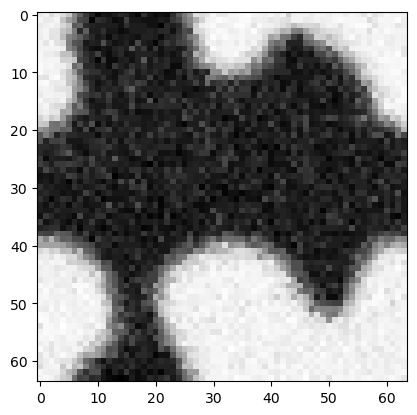

In [23]:
plt.imshow(input_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

In [24]:
threshold = 25

grid = input_state[0].detach().clone()
grid[grid < 25] = 0
grid[grid >= 25] = 1
grid = grid.unsqueeze(0)

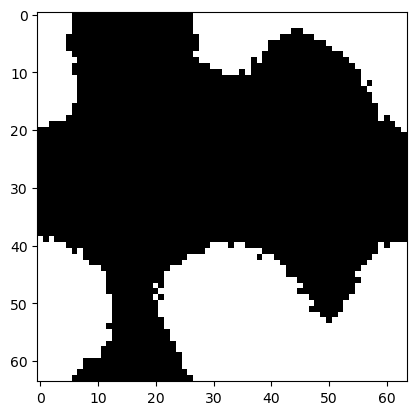

In [25]:
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [26]:
test_grid = grid.detach().clone()

In [27]:
test_grid.requires_grad_()
loss = loss_fn(test_grid, input_state)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


In [28]:
loss

tensor(6655.6289, grad_fn=<AddBackward0>)

In [29]:
t.autograd.grad(loss, test_grid)

(tensor([[[89.9993, 89.9993, 89.9992,  ..., 89.9992, 89.9993, 89.9993],
          [89.9993, 89.9993, 89.9993,  ..., 89.9993, 89.9993, 89.9992],
          [89.9993, 89.9993, 89.9994,  ..., 89.9992, 89.9992, 89.9993],
          ...,
          [89.9991, 89.9993, 89.9993,  ..., 89.9992, 89.9993, 89.9992],
          [89.9993, 89.9993, 89.9993,  ..., 89.9993, 89.9993, 89.9993],
          [89.9993, 89.9994, 89.9994,  ..., 89.9993, 89.9993, 89.9993]]]),)

In [30]:
for i in range(1000):
    loss = loss_fn(test_grid, input_state)
    grads = t.autograd.grad(loss, test_grid)[0]
    test_grid = t.clamp(test_grid - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


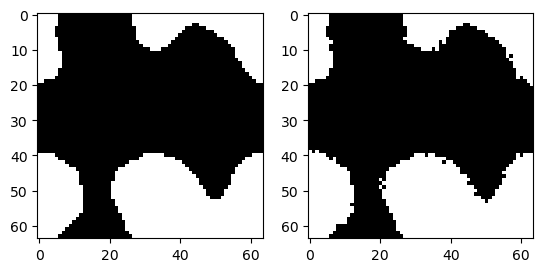

In [31]:
opt_grid = grid2gsc(test_grid, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[0].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].imshow(grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

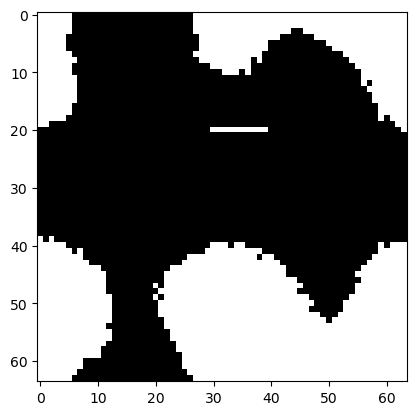

In [32]:
test2 = grid.detach().clone()
test2[0,20,30:40] = 0
plt.imshow(test2[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [33]:
train_test2 = test2.detach().clone()
train_test2.requires_grad_()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)

In [34]:
for i in range(1000):
    loss = loss_fn(train_test2, input_state)
    grads = t.autograd.grad(loss, train_test2)[0]
    train_test2 = t.clamp(train_test2 - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


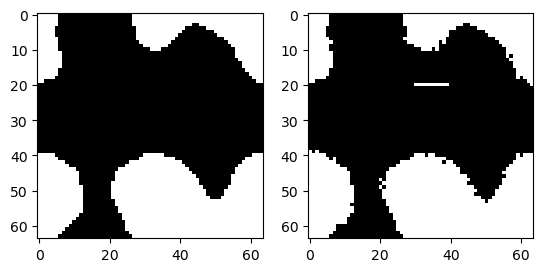

In [35]:
opt_grid = grid2gsc(train_test2, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[0].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].imshow(test2[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [36]:
test3 = test2.detach().clone()
test3[0,20:25,10:20] = 0

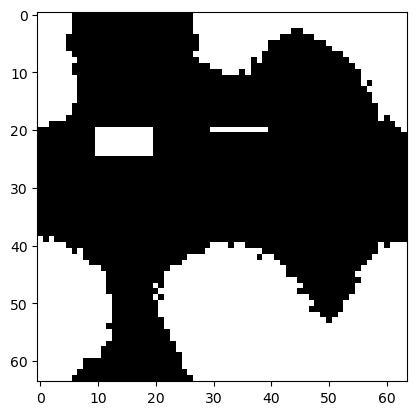

In [37]:
plt.imshow(test3[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [38]:
train_test3 = test3.detach().clone()
train_test3.requires_grad_()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)

In [39]:
for i in range(1000):
    loss = loss_fn(train_test3, input_state)
    grads = t.autograd.grad(loss, train_test3)[0]
    train_test3 = t.clamp(train_test3 - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'initial')

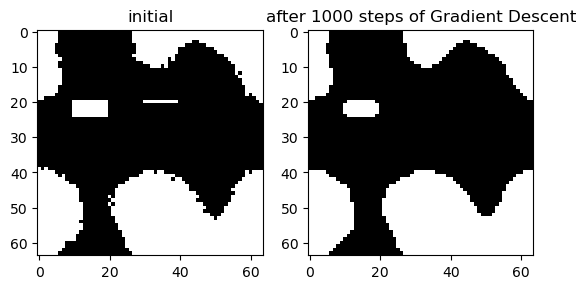

In [40]:
opt_grid = grid2gsc(train_test3, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[1].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("after 1000 steps of Gradient Descent")
axs[0].imshow(test3[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)
axs[0].set_title("initial")

In [41]:
input_state_ref = input_state[0].detach().clone().unsqueeze(0)
input_state_ref[0,20,30:40] = 0
input_state_ref[0,20:25,10:20] = 0

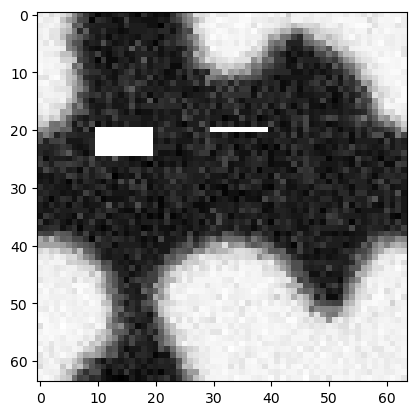

In [42]:
plt.imshow(input_state_ref[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

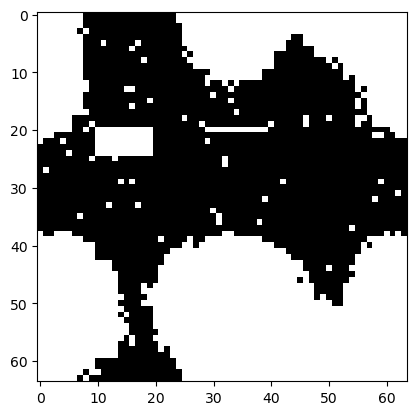

In [43]:
threshold = 40

grid = input_state[0].detach().clone()
grid[grid < threshold] = 0
grid[grid >= threshold] = 1
grid = grid.unsqueeze(0)
grid[0,20,30:40] = 0
grid[0,20:25,10:20] = 0
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [44]:
ex_3_grid = grid.detach().clone()
ex_3_grid.requires_grad_()
for i in range(1000):
    loss = loss_fn(ex_3_grid, input_state)
    grads = t.autograd.grad(loss, ex_3_grid)[0]
    ex_3_grid = t.clamp(ex_3_grid - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        [0.9300, 0.0700],
        [0.9500, 0.0500],
        [0.9900, 0.0100],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'initial')

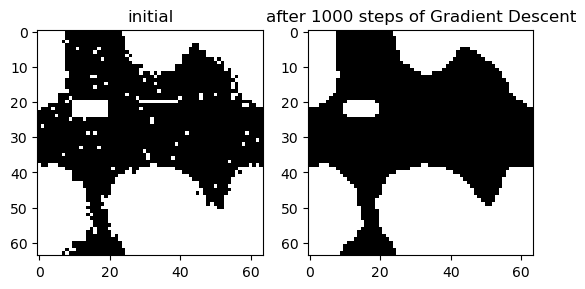

In [45]:
opt_grid = grid2gsc(ex_3_grid, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[1].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("after 1000 steps of Gradient Descent")
axs[0].imshow(grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)
axs[0].set_title("initial")

In [6]:
from os import path, listdir, getcwd
nuclei_path = path.join(getcwd(), "data", "nuclei")
listdir(nuclei_path)

['79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96',
 '7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105',
 'a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731',
 '9774c82396327929fea05e40ae153cabf0107178b2ae3e40a5709b409793887e',
 'be26966900aa0e5b41d5a8ecafe04281b37deb05c5cd027968d7b74143398174',
 'a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629',
 '709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7',
 'cdab367b30db47061df837c1ae9fa875d6057614f797332d37d3513517d6c694',
 '953211bcc0192e2298087d30e708dba68def9e0c13a3ff3326a18b0962c63adc',
 '6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56',
 'fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae',
 '449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b',
 '54cb3328e778d87f76062b0550e3bc190f46384acd8efbe58c297265d1906e84',
 'b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48',
 '58406ed8ef944831c413c3424dc2b07e

(360, 360, 4)


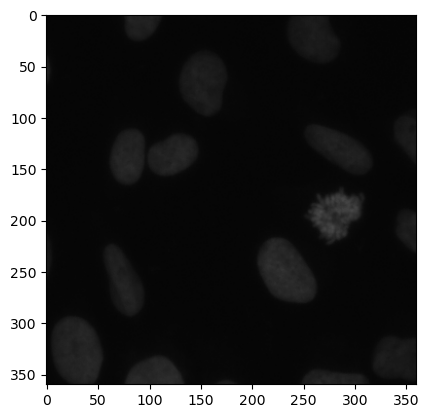

In [7]:
import matplotlib.image as mpimg
input_path = path.join(nuclei_path, listdir(nuclei_path)[-1])
image_path = path.join(input_path, "images", listdir(path.join(input_path, "images"))[-1])
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)

(360, 360, 3)


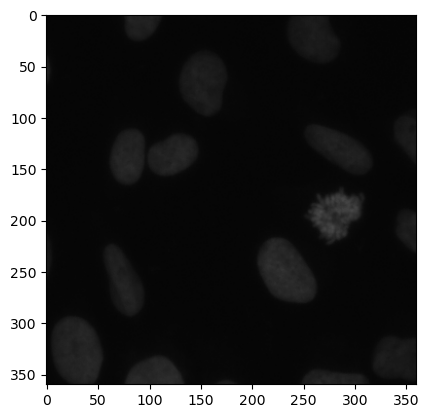

In [8]:
from skimage.color import rgba2rgb
img_rgb = rgba2rgb(img)
print(img_rgb.shape)
plt.imshow(img_rgb)

(360, 360)


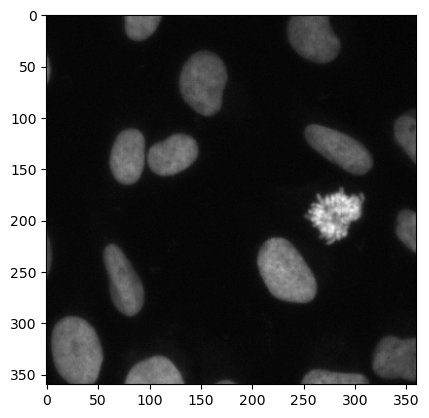

In [9]:
from skimage.color import rgb2gray
img_gsc = rgb2gray(img_rgb)
print(img_gsc.shape)
plt.imshow(img_gsc, cmap=plt.cm.gray)

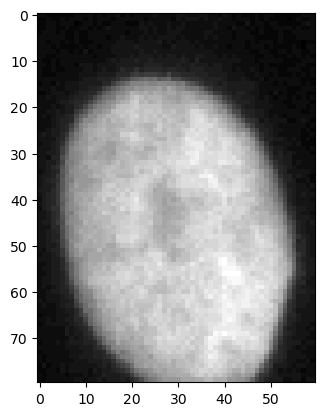

In [27]:
snippet = img_gsc[280:, :60]
plt.imshow(snippet, cmap=plt.cm.gray)

In [11]:
grid = t.zeros_like(t.tensor(snippet))
grid = grid.unsqueeze(0)
ref = t.from_numpy(snippet)
ref = ref.unsqueeze(0)

In [12]:
def grid2gsc(grid, scale_min, scale_max):
    mask = t.logical_and(grid != 0, grid != 1)
    #print(mask)
    p_vec = grid[mask].unsqueeze(1)
    p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
    #print(p_vec_expanded)
    gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
    #print(gumbel_samples)
    cell_ids = 1 - gumbel_samples[:, 0]
    reconstruction = t.zeros(*grid.shape, device="cpu")
    reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
    reconstruction[mask] += cell_ids
    reconstruction *= scale_max
    reconstruction[reconstruction == 0] += scale_min
    return reconstruction

In [13]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [14]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [36]:
def loss_fn(grid, ref_pic, max_intensity):
    conv_mat = unfold_conv(grid)
    rec_pic = grid2gsc(grid, scale_min=0, scale_max=1)
    #fig, axs = plt.subplots(1,2)
    #axs[0].imshow(rec_pic.detach().squeeze().numpy())
    #axs[1].imshow(ref_pic.detach().squeeze().numpy())
    return reconstruction_loss(ref_pic, grid, max_intensity)

In [37]:
def reconstruction_loss(ref_pic, grid, max_intensity):
    return t.log(t.sum((ref_pic - grid*max_intensity)**2))

In [38]:
grid[:] = 0

In [48]:
from tqdm import tqdm
max_intensity = t.max(ref)
grid.requires_grad_()
for i in tqdm(range(1000)):
    loss = loss_fn(grid, ref, max_intensity)
    grads = t.autograd.grad(loss, grid)[0]
    #print(grads)
    grid = t.clamp(grid - 0.01 * grads, min=0, max=1)

100%|██████████| 1000/1000 [00:07<00:00, 132.83it/s]


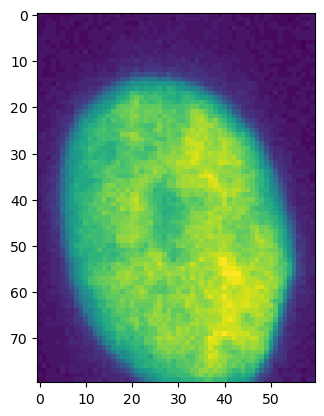

In [49]:
plt.imshow(grid.detach().squeeze().numpy())

In [47]:
grid

tensor([[[0.0004, 0.0004, 0.0003,  ..., 0.0004, 0.0004, 0.0004],
         [0.0003, 0.0003, 0.0004,  ..., 0.0003, 0.0003, 0.0004],
         [0.0003, 0.0003, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         ...,
         [0.0003, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0004],
         [0.0004, 0.0003, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
         [0.0003, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0004]]],
       grad_fn=<ClampBackward1>)

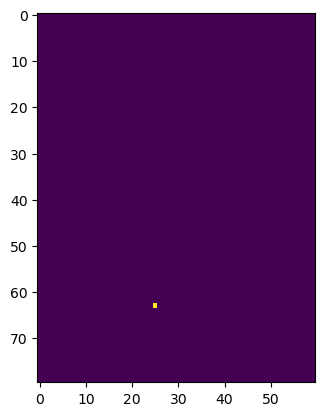

In [41]:

mask = t.logical_and(grid != 0, grid != 1)
#print(mask)
p_vec = grid[mask].unsqueeze(1)/max_intensity
p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
#print(p_vec_expanded)
gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
#print(gumbel_samples)
cell_ids = 1 - gumbel_samples[:, 0]
reconstruction = t.zeros(*grid.shape, device="cpu")
reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
reconstruction[mask] += cell_ids
plt.imshow(reconstruction.detach().squeeze().numpy())